### Practice 2: Frequency Domain and Aliasing

In [343]:
import numpy as np
import AshfordSignals as sigsys
import math
import copy
import matplotlib.pyplot as plt
from IPython.display import Audio

In [344]:
class Signal:
    def __add__(self, other):
        """Adds two signals"""
        if(other == 0):
            return self
        else:
            return SumSignal(self, other)
    
    def make_wave(self, duration=1, start=0, framerate=11025):
        """Makes a Wave object.

        duration: float seconds
        start: float seconds
        framerate: int frames per second

        returns: Wave
        """
        n = round(duration * framerate)
        ts = start + np.arange(n) / framerate
        ys = self.evaluate(ts)
        return Wave(ys, ts, framerate=framerate)

    def plot(self, duration=None, period_length=3, **options):
        if duration is None:
            duration = self.period * period_length
        wave = self.make_wave(duration)
        wave.plot()
        
    def make_audio(self, duration = 3):
        wave = self.make_wave(duration)
        wave.make_audio()

In [345]:
class SumSignal(Signal):
    def __init__(self, *args):
        self.signals = args
    
    @property
    def period(self):
        return max(signal.period for signal in self.signals)
    
    def evaluate(self, ts):
        ts = np.asarray(ts)
        return sum(signal.evaluate(ts) for signal in self.signals)

In [346]:
## START NEW CODE:
class SquareSignal(Sinusoid):
    """Represents a square signal."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times

        returns: float wave array
        """
        ts = np.asarray(ts)
        cycles = self.freq * ts + self.offset / (math.pi * 2)
        frac, _ = np.modf(cycles)
        ys = self.amp * np.sign(frac - frac.mean())
        return ys
## END NEW CODE

In [347]:
class Sinusoid(Signal):
    """Represents sinusoidal signal"""
    
    def __init__(self, freq=440, amp=1.0, offset=0, func=np.sin):
        self._freq = freq
        self.amp = amp
        self.offset = offset
        self.func = func
    
    ##Get function
    @property
    def period(self):
        return 1.0 / self.freq
    
    @property
    def freq(self):
        return self._freq
    

    ## Evaluate - producing the signal from the properties
    def evaluate(self, ts):
        """ts is a float array of times that would come from the Wave class"""
        "phase = 2*pi*f*t + offset"
        ts = np.asarray(ts)
        phases = 2 * math.pi * self.freq * ts + self.offset
        ys = self.amp * self.func(phases)
        return ys

In [348]:
def CosSignal(freq, amp=1.0, offset=0):
    return Sinusoid(freq, amp, offset, func=np.cos)

In [349]:
def SinSignal(freq, amp=1.0, offset=0):
    return Sinusoid(freq, amp, offset, func=np.sin)

In [350]:
class Wave:
    """Class is meant to take in a Signal and return a certain wave interval"""
    def __init__(self, ys, ts=None, framerate=None):
        self.ys = np.asarray(ys)
        "Initializes framerate default value"
        self.framerate = framerate if not None else 11025
        if ts is None:
            self.ts = np.arange(len(ys)) / self.framerate
        else:
            self.ts = np.asarray(ts)
            
    def plot(self, **options):
        """plots the real value of the Wave"""
        """**args passes a dictionary of arguments that maps to values - can be inserted into plot()"""
        plt.plot(self.ts, np.real(self.ys), **options)
    
    def make_audio(self):
        return Audio(data=self.ys.real, rate=self.framerate)
    
    ## START NEW CODE:
    def make_spectrum(self, full=False):
        """Makes frequency spectrum using a NumPy helper function"""
        n = len(self.ys)
        d = 1 / self.framerate

        if full:
            hs = np.fft.fft(self.ys)
            fs = np.fft.fftfreq(n, d)
        else:
            hs = np.fft.rfft(self.ys)
            fs = np.fft.rfftfreq(n, d)
        
        return Spectrum(hs, fs, self.framerate, full)
    
    def make_segment(self, start=None, duration=None):
        """Extracts a segment.

        start: float start time in seconds
        duration: float duration in seconds

        returns: Wave
        """
        if start is None:
            start = self.ts[0]
            i = 0
        else:
            i = self.find_index(start)

        j = None if duration is None else self.find_index(start + duration)
        return self.slice(i, j)
    
    def slice(self, i, j):
        """Makes a slice from a Wave.

        i: first slice index
        j: second slice index
        """
        ys = self.ys[i:j].copy()
        ts = self.ts[i:j].copy()
        return Wave(ys, ts, self.framerate)
    
    @property
    def start(self):
        return self.ts[0]

    @property
    def end(self):
        return self.ts[-1]

    @property
    def duration(self):
        """Duration (property).

        returns: float duration in seconds
        """
        return len(self.ys) / self.framerate
    
    def find_index(self, t):
        """Find the index corresponding to a given time."""
        n = len(self)
        start = self.start
        end = self.end
        i = round((n - 1) * (t - start) / (end - start))
        return int(i)
    
    def __len__(self):
        return len(self.ys)
    
    ## END NEW CODE

In [351]:
def decorate(**options):
    plt.gca().set(**options)
    plt.tight_layout()

In [352]:
## START NEW CODE:
class Spectrum:
    def __init__(self, hs, fs, framerate, full=False):
        self.hs = np.asanyarray(hs) #array of amplitudes of frequencies
        self.fs = np.asanyarray(fs) #array of frequencies
        self.framerate = framerate
        self.full = full
    
    @property
    def freq_res(self):
        return self.framerate / 2 / (len(self.fs) - 1)
    
    @property
    def max_freq(self):
        return self.framerate / 2
        
    @property
    def real(self):
        return np.real(self.hs)
    
    @property
    def imag(self):
        return np.imag(self.hs)
    
    @property
    def amps(self):
        """Returns a sequence of amplitudes (read-only property)."""
        return np.absolute(self.hs)

    
    def plot(self, high=None, **options):
        if self.full:
            fs, amps = self.render_full(high)
            plt.plot(fs, amps, **options)
        else:
            i = None if high is None else find_index(high, self.fs)
            plt.plot(self.fs[:i], self.amps[:i], **options)
        
    def make_wave(self):
        """Transforms to the time domain.

        returns: Wave
        """
        if self.full:
            ys = np.fft.ifft(self.hs)
        else:
            ys = np.fft.irfft(self.hs)

        # NOTE: whatever the start time was, we lose it when
        # we transform back; we could fix that by saving start
        # time in the Spectrum
        # ts = self.start + np.arange(len(ys)) / self.framerate
        return Wave(ys, framerate=self.framerate)
        
    def render_full(self, high=None):
        """Extracts amps and fs from a full spectrum.

        high: cutoff frequency

        returns: fs, amps
        """
        hs = np.fft.fftshift(self.hs)
        amps = np.abs(hs)
        fs = np.fft.fftshift(self.fs)
        i = 0 if high is None else find_index(-high, fs)
        j = None if high is None else find_index(high, fs) + 1
        return fs[i:j], amps[i:j]
## END NEW CODE

### Obtaining Spectrum of a Sinusoidal Wave

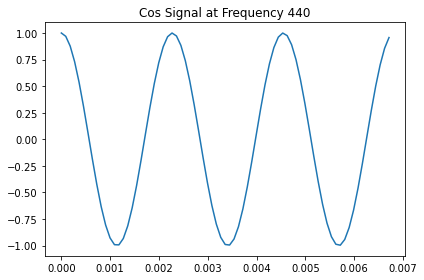

In [353]:
cosSignalOne = CosSignal(freq=440)
cosSignalOne.plot(period_length=3)
decorate(title='Cos Signal at Frequency 440')

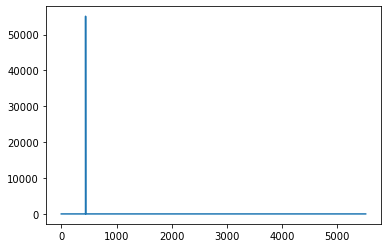

In [354]:
cosWaveOne = cosSignalOne.make_wave(duration=10)
cosSpectrum = cosWaveOne.make_spectrum()
cosSpectrum.plot()

### Adding Signals Sharing Fundamental Frequency Multipliers

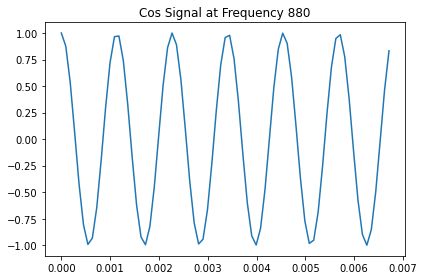

In [355]:
duration = cosSignalOne.period * 3

cosSignalOneDoubled = CosSignal(cosSignalOne.freq * 2)
cosSignalOneDoubled.plot(duration=duration)
decorate(title='Cos Signal at Frequency 880')

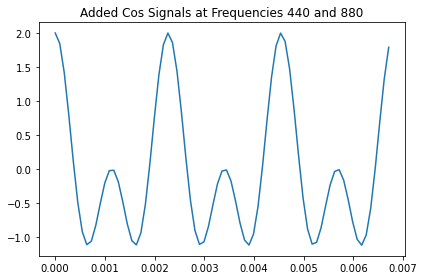

In [356]:
cosSignalOneAndTwo = cosSignalOne + cosSignalOneDoubled
cosSignalOneAndTwo.plot(duration=duration)
decorate(title='Added Cos Signals at Frequencies 440 and 880')
cosWaveOneAndTwo = cosSignalOneAndTwo.make_wave(duration=3)
cosWaveOneAndTwo.make_audio()

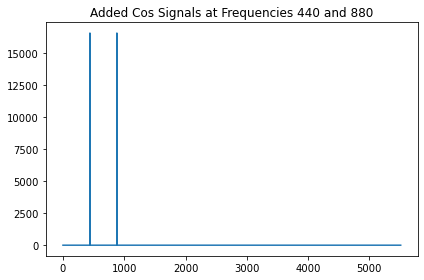

In [357]:
cosSpectrum = cosWaveOneAndTwo.make_spectrum()
cosSpectrum.plot()
decorate(title='Added Cos Signals at Frequencies 440 and 880')

### Frequencies of Square Waves

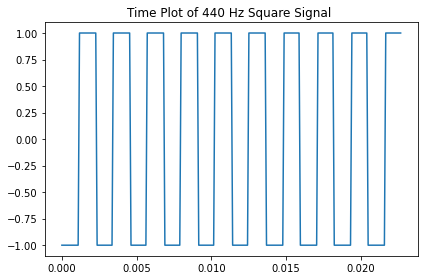

In [358]:
squareSignal = SquareSignal(440)
squareSignal.plot(period_length=10)
decorate(title='Time Plot of 440 Hz Square Signal ')


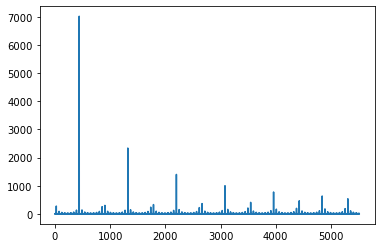

In [359]:
squareWave = squareSignal.make_wave()
squareSpectrum = squareWave.make_spectrum()
squareSpectrum.plot()

### Aliasing of a Cos Wave

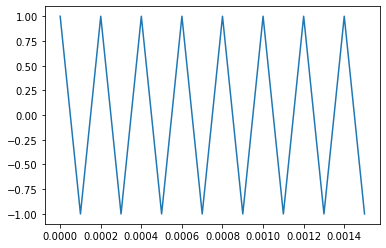

In [360]:
cosSignalUnaliased = CosSignal(freq=5000)
cosSignalAliased = CosSignal(freq=6000)

cosWaveUnaliased = cosSignalUnaliased.make_wave(framerate=10000)
cosWaveAliased = cosSignalAliased.make_wave(framerate=10000)

unaliasedSegment = cosWaveUnaliased.make_segment(duration=(cosSignalUnaliased.period * 8))
aliasedSegment = cosWaveAliased.make_segment(duration=(cosSignalAliased.period * 8))

unaliasedSegment.plot()


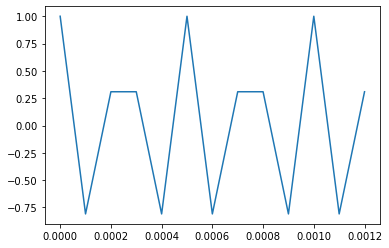

In [361]:
aliasedSegment.plot()